In [1]:
import xarray as xr
import numpy as np

# Charger le fichier NetCDF
file_path = "/Volumes/ref-argo/gdac/dac/coriolis/6902807/6902807_Sprof.nc"
dataset = xr.open_dataset(file_path)

# Extraire les variables utiles
cycle_numbers = dataset["CYCLE_NUMBER"].values
pressure = dataset["PRES"].values
doxy = dataset["DOXY"].values
doxy_qc = dataset["DOXY_QC"].values  # Qualité des mesures

# Convertir les valeurs invalides en NaN
doxy = np.where(doxy_qc.astype(str) != "4", doxy, np.nan)

# Calculer la variation moyenne de DOXY entre les cycles
std_per_cycle = [np.nanstd(doxy[i]) for i in range(len(cycle_numbers))]

# Déterminer le cycle où la variation devient stable
threshold = np.nanmedian(std_per_cycle) * 0.1  # Seuil de stabilisation
stable_cycle = next((cycle_numbers[i] for i in range(1, len(std_per_cycle)) 
                     if abs(std_per_cycle[i] - std_per_cycle[i-1]) < threshold), None)

print(f"Le capteur DOXY est stabilisé à partir du cycle {stable_cycle}.")

Le capteur DOXY est stabilisé à partir du cycle 5.0.


/Users/chemon/miniconda3/envs/locodox_env/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [2]:
import xarray as xr
import numpy as np
from scipy.interpolate import interp1d

file_path = "/Volumes/ref-argo/gdac/dac/coriolis/6902807/6902807_Sprof.nc"
dataset = xr.open_dataset(file_path)

# Extraire les variables utiles
cycle_numbers = dataset["CYCLE_NUMBER"].values
pressure = dataset["PRES"].values  # (cycles, niveaux de pression)
doxy = dataset["DOXY"].values
doxy_qc = dataset["DOXY_QC"].values  # Qualité des mesures

# Filtrer les valeurs invalides (QC ≠ 1 devient NaN)
#doxy = np.where(doxy_qc.astype(str) != "4", doxy, np.nan)

# Définir une grille de pression commune (de min à max avec 50 points)
common_pres = np.linspace(np.nanmin(pressure), np.nanmax(pressure), 50)
common_pres = np.linspace(1000, np.nanmax(pressure), 50)

# Interpoler chaque profil DOXY sur cette grille de pression
interpolated_doxy = []
for i in range(len(cycle_numbers)):
    valid_mask = ~np.isnan(pressure[i]) & ~np.isnan(doxy[i])  # Points valides
    if np.sum(valid_mask) > 2:  # Vérifie qu'on a assez de points valides
        interp_func = interp1d(pressure[i][valid_mask], doxy[i][valid_mask], 
                               kind="linear", bounds_error=False, fill_value=np.nan)
        interpolated_doxy.append(interp_func(common_pres))
    else:
        interpolated_doxy.append(np.full_like(common_pres, np.nan))

interpolated_doxy = np.array(interpolated_doxy)  # Convertir en tableau NumPy

# Calculer la variation moyenne entre les profils interpolés successifs
cycle_differences = []
for i in range(1, len(cycle_numbers)):
    diff = np.nanmean(np.abs(interpolated_doxy[i] - interpolated_doxy[i-1]))
    cycle_differences.append(diff)

# Déterminer le cycle où la variation devient stable
threshold = np.nanmedian(cycle_differences) * 0.1  # Seuil de stabilisation
threshold = 0.5
#stable_cycle = next((cycle_numbers[i] for i in range(1, len(cycle_differences)) 
#                     if cycle_differences[i] < threshold), None)
stable_cycle = None

for i in range(1, len(cycle_differences) - 1):
    if (cycle_differences[i] < threshold) and (cycle_differences[i+1] < threshold):
        stable_cycle = cycle_numbers[i+1]  # Le second cycle où la condition est remplie
        break  # On sort dès qu'on trouve le premier cas

print(f"Le capteur DOXY est stabilisé à partir du cycle {stable_cycle}.")


Le capteur DOXY est stabilisé à partir du cycle 14.0.


/var/folders/vb/_nx050wx16vc32wc3vf7tkrw000h29/T/ipykernel_19317/3665023453.py:37: RuntimeWarning: Mean of empty slice
  diff = np.nanmean(np.abs(interpolated_doxy[i] - interpolated_doxy[i-1]))


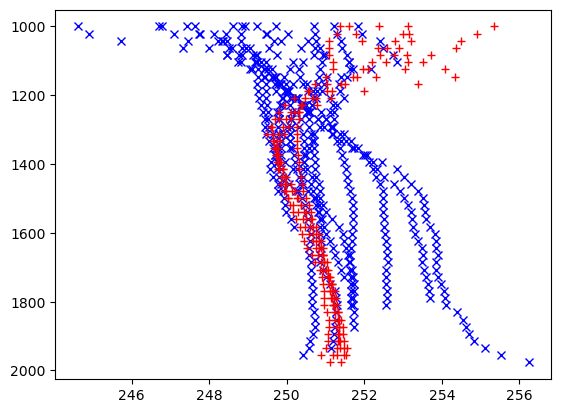

In [22]:
import matplotlib.pyplot as plt
pres_plot = np.tile(common_pres, (interpolated_doxy.shape[0], 1)) 
plt.figure()
_=plt.plot(interpolated_doxy[0:15,:],pres_plot[0:15,:],'xb')
_=plt.plot(interpolated_doxy[15:20,:],pres_plot[15:20,:],'+r')

plt.gca().invert_yaxis()

In [15]:
pres_plot.shape

(272, 50)

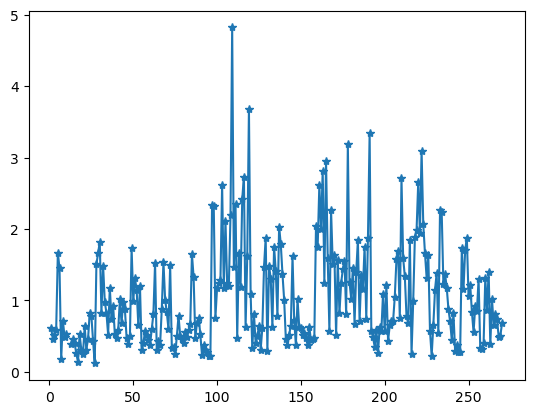

In [49]:
plt.figure()
plt.plot(cycle_differences,'*-')

In [65]:
threshold = np.nanmedian(cycle_differences) * 0.1  # Seuil de stabilisation
print(threshold)
print(cycle_differences)

0.07981999291292287
[nan, 0.6142996127800419, 0.4654801992712859, 0.5205717343805822, 0.590205253884918, 1.667029404013114, 1.4510966540912886, 0.18429037824076153, 0.7177948796006627, 0.49352675400219714, 0.5321250314883881, nan, nan, 0.3887466379757798, 0.45957329739194963, 0.4030917189186602, 0.2591345354200574, 0.140700252956373, 0.5252240714058986, 0.31126043189776, 0.2558570902567426, 0.6363053189277276, 0.3140498990173004, 0.4567550877907885, 0.8252596061780282, 0.784832773264437, 0.43899745072256763, 0.11889685594255184, 1.5060855658477244, 1.6588298990072339, 1.8168906170234245, 0.8319749127430663, 1.4869389455623199, 0.9850395362178893, 0.8196324216958603, 0.5201871016819256, 1.180567288604421, 0.7441248974557446, 0.9213418617854571, 0.5285573360609002, 0.47735746085313163, 0.5842293593790675, 1.01794692449089, 0.6844449043129573, 0.9849288670820722, 0.8785151958197659, 0.4803073380546821, 0.38573667481717483, 0.498329646934766, 1.7300154133750842, 0.9949856533944307, 1.31041

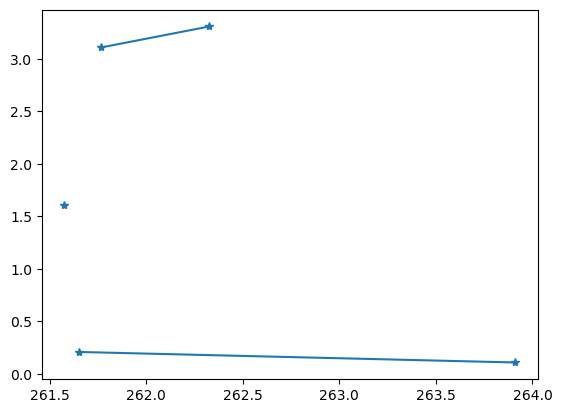

In [58]:
plt.figure()
plt.plot(doxy[12],pressure[12],'*-')